## **Classification of Disaster vs Non-Disaster tweets using Supervised Machine Learning**


Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

This notebook involves in building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have a dataset of 10,000 tweets that were hand classified. Let's start.

---

---





This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

---

---

---







I have decided to break this notebook as three diffferent parts namely, basic data preprocessing, data visualization, data modelling.

Installing and importing necessary packages before starting.


In [1]:
pip install contractions  

     |████████████████████████████████| 321 kB 1.2 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=102848 sha256=2373115071666001a9685ef8cef3ceb1b30e6364dbd6ee82d8f902d1d21e88fe
  Stored in directory: /root/.cache/pip/wheels/fe/ea/e6/38b0d734be6936b783e916a0d8d670313fb1b2f74c5889d4fe
Successfully built pyahocorasick
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install stop_words

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
nltk.download('punkt')
import contractions
from stop_words import get_stop_words
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [5]:
#reading the data
data_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
data_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [6]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print('rows * columns = '+str(data_train.shape))
print('Size = '+str(data_train.size))
print('Columns = '+str(data_train.columns))

rows * columns = (7613, 5)
Size = 38065
Columns = Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


Dataset Overview:

In [8]:
print('rows * columns = '+str(data_test.shape))
print('Size = '+str(data_test.size))
print('Columns = '+str(data_test.columns))

rows * columns = (3263, 4)
Size = 13052
Columns = Index(['id', 'keyword', 'location', 'text'], dtype='object')


Dataset cleaning:

In [9]:
print('Missing values in train dataset')
print(data_train.isnull().sum())
print('Missing values in test dataset')
print(data_test.isnull().sum())

Missing values in train dataset
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Missing values in test dataset
id             0
keyword       26
location    1105
text           0
dtype: int64


Missing value rate

In [10]:
location_miss_rate_train = 1 - (data_train['location'].count() - data_train['location'].isnull().sum())/data_train['location'].count()
print('Column: Location missing rate in training data {:.2%}'.format(location_miss_rate_train))

location_miss_rate_test = 1 - (data_test['location'].count() - data_test['location'].isnull().sum())/data_test['location'].count()
print('Column: Location missing rate in test data {:.2%}'.format(location_miss_rate_test))

Column: Location missing rate in training data 49.86%
Column: Location missing rate in test data 51.20%


In [11]:
data_train['location'].fillna('None',inplace=True)
data_test['location'].fillna('None',inplace=True)


In [12]:
data_train['text'] = data_train['location']+' '+data_train['text']
data_test['text'] = data_test['location']+' '+data_test['text']

Here, Location has almost 50% of the data missing in both train and test dataset. Instead of dropping them due to inconsistency, what we can do is replace the unknown values by **None** and join the location to the tweets as location can add value to the tweets, which we will discuss shortly.

In [13]:
keyword_miss_rate_train = 1 - (data_train['keyword'].count() - data_train['keyword'].isnull().sum())/data_train['keyword'].count()
print('Keyword missing rate in training data {:.1%}'.format(keyword_miss_rate_train))

keyword_miss_rate_test = 1 - (data_test['keyword'].count() - data_test['keyword'].isnull().sum())/data_test['keyword'].count()
print('Keyword missing rate in test data {:.1%}'.format(keyword_miss_rate_test))
print(' ')
print('Since only 0.8% of data in both train and test data has missing keywords we can choose to replace them with None values')


Keyword missing rate in training data 0.8%
Keyword missing rate in test data 0.8%
 
Since only 0.8% of data in both train and test data has missing keywords we can choose to replace them with None values


In [14]:
print("Shape of train dataset before removing duplicates in text " +str(data_train.shape))
data_train.drop_duplicates("text", keep='first', inplace=True)
print("Shape of train dataset after removing duplicates in text " +str(data_train.shape))

print("Shape of test dataset before removing duplicates in text " +str(data_test.shape))
data_test.drop_duplicates("text", keep='first', inplace=False)
print("Shape of test dataset after removing duplicates in text " +str(data_test.shape))

Shape of train dataset before removing duplicates in text (7613, 5)
Shape of train dataset after removing duplicates in text (7531, 5)
Shape of test dataset before removing duplicates in text (3263, 4)
Shape of test dataset after removing duplicates in text (3263, 4)


Test cleaning & visualization

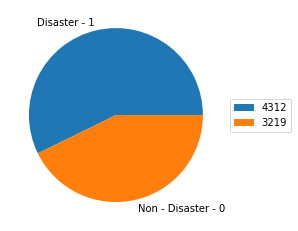

In [15]:
plt.pie(data_train['target'].value_counts(),labels=['Disaster - 1', 'Non - Disaster - 0'])
plt.legend(data_train['target'].value_counts(),bbox_to_anchor=(1, 0, 0.5, 1),loc='center left')

In [16]:
data_0 = data_train[data_train['target']==0]["target"].count() / data_train['target'].count()
data_1 = data_train[data_train['target']==1]["target"].count() / data_train['target'].count()

print('Rate of Disasterous tweets {:.2%}'.format(data_1))
print('Rate of Non - Disasterous tweets {:.2%}'.format(data_0))
print()
print('Though the data is not completely balanced, they are almost balanced')

Rate of Disasterous tweets 42.74%
Rate of Non - Disasterous tweets 57.26%

Though the data is not completely balanced, they are almost balanced


Before preprocessing the data, lets try to find some insights with the raw data between disasterous and non disasterous tweets in both training and testing datasets.

By visualizing both the datasets we can ensure whether both training and testing dataset is from the same population.

This can also help us to compare whether the datasets retain their core features post preprocessing.


At the same time, we should be cautious not to rigorously preprocess the data, as we know that in realtime implementation we can't expect the data to be completely clean.

In [17]:
print('No of stop words in english = '+str(len(get_stop_words('english'))))
print('')

stop_word = get_stop_words('english')
print('First 10 stop words' +str(stop_word[:10])) 

to_be_removed = ['no','nor','not']
to_be_added = ['also','called','like','will','that','make','could','about','into','said','when','should','being','some','also','with','will','this','your','then','made','is','were','that','going','would','just','about']

removed_stop_word = list(set(stop_word)-set(to_be_removed))
final_stop_word = removed_stop_word + to_be_added

print('')
print('Final stop words = ' +str(len(final_stop_word)))

No of stop words in english = 174

First 10 stop words['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

Final stop words = 199


The below cell involves in extracting the 

1.   punctuation count
2.   average word count
3.   hashtags
4.   mention counts
5.   url counts
6.   stopwords count
7.   unique word counts
in both disaterous and non- disasterous data in training and test datasets

In [18]:
data_train['punctuation_count'] = data_train['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
data_train['letter_count'] = data_train['text'].apply(lambda x: len(x))
data_train['word_count'] = data_train['text'].apply(lambda x: len([i for i in str(x).split(' ')]))
data_train['mention_count'] = data_train['text'].apply(lambda x: len([i for i in str(x) if i == '@']))
data_train['url_count'] = data_train['text'].apply(lambda x: len([i for i in str(x) if 'http' in i or 'https' in i]))
data_train['hashtag_count'] = data_train['text'].apply(lambda x: len([i for i in str(x) if i == '#']))
data_train['stopword_count'] = data_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in final_stop_word]))
data_train['unique_word_count'] = data_train['text'].apply(lambda x: len([set(i) for i in str(x).split(' ')]))
data_train['avg_word_count'] = np.ceil(data_train['letter_count']/data_train['word_count'])

data_test['punctuation_count'] = data_test['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
data_test['letter_count'] = data_test['text'].apply(lambda x: len(x))
data_test['word_count'] = data_test['text'].apply(lambda x: len([i for i in str(x).split(' ')]))
data_test['mention_count'] = data_test['text'].apply(lambda x: len([i for i in str(x) if i == '@']))
data_test['hashtag_count'] = data_test['text'].apply(lambda x: len([i for i in str(x) if i == '#']))
data_test['url_count'] = data_test['text'].apply(lambda x: len([i for i in str(x) if 'http' in i or 'https' in i]))
data_test['stopword_count'] = data_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in final_stop_word]))
data_test['unique_word_count'] = data_test['text'].apply(lambda x: len([set(i) for i in str(x).split(' ')]))
data_test['avg_word_count'] = np.ceil(data_test['letter_count']/data_test['word_count'])

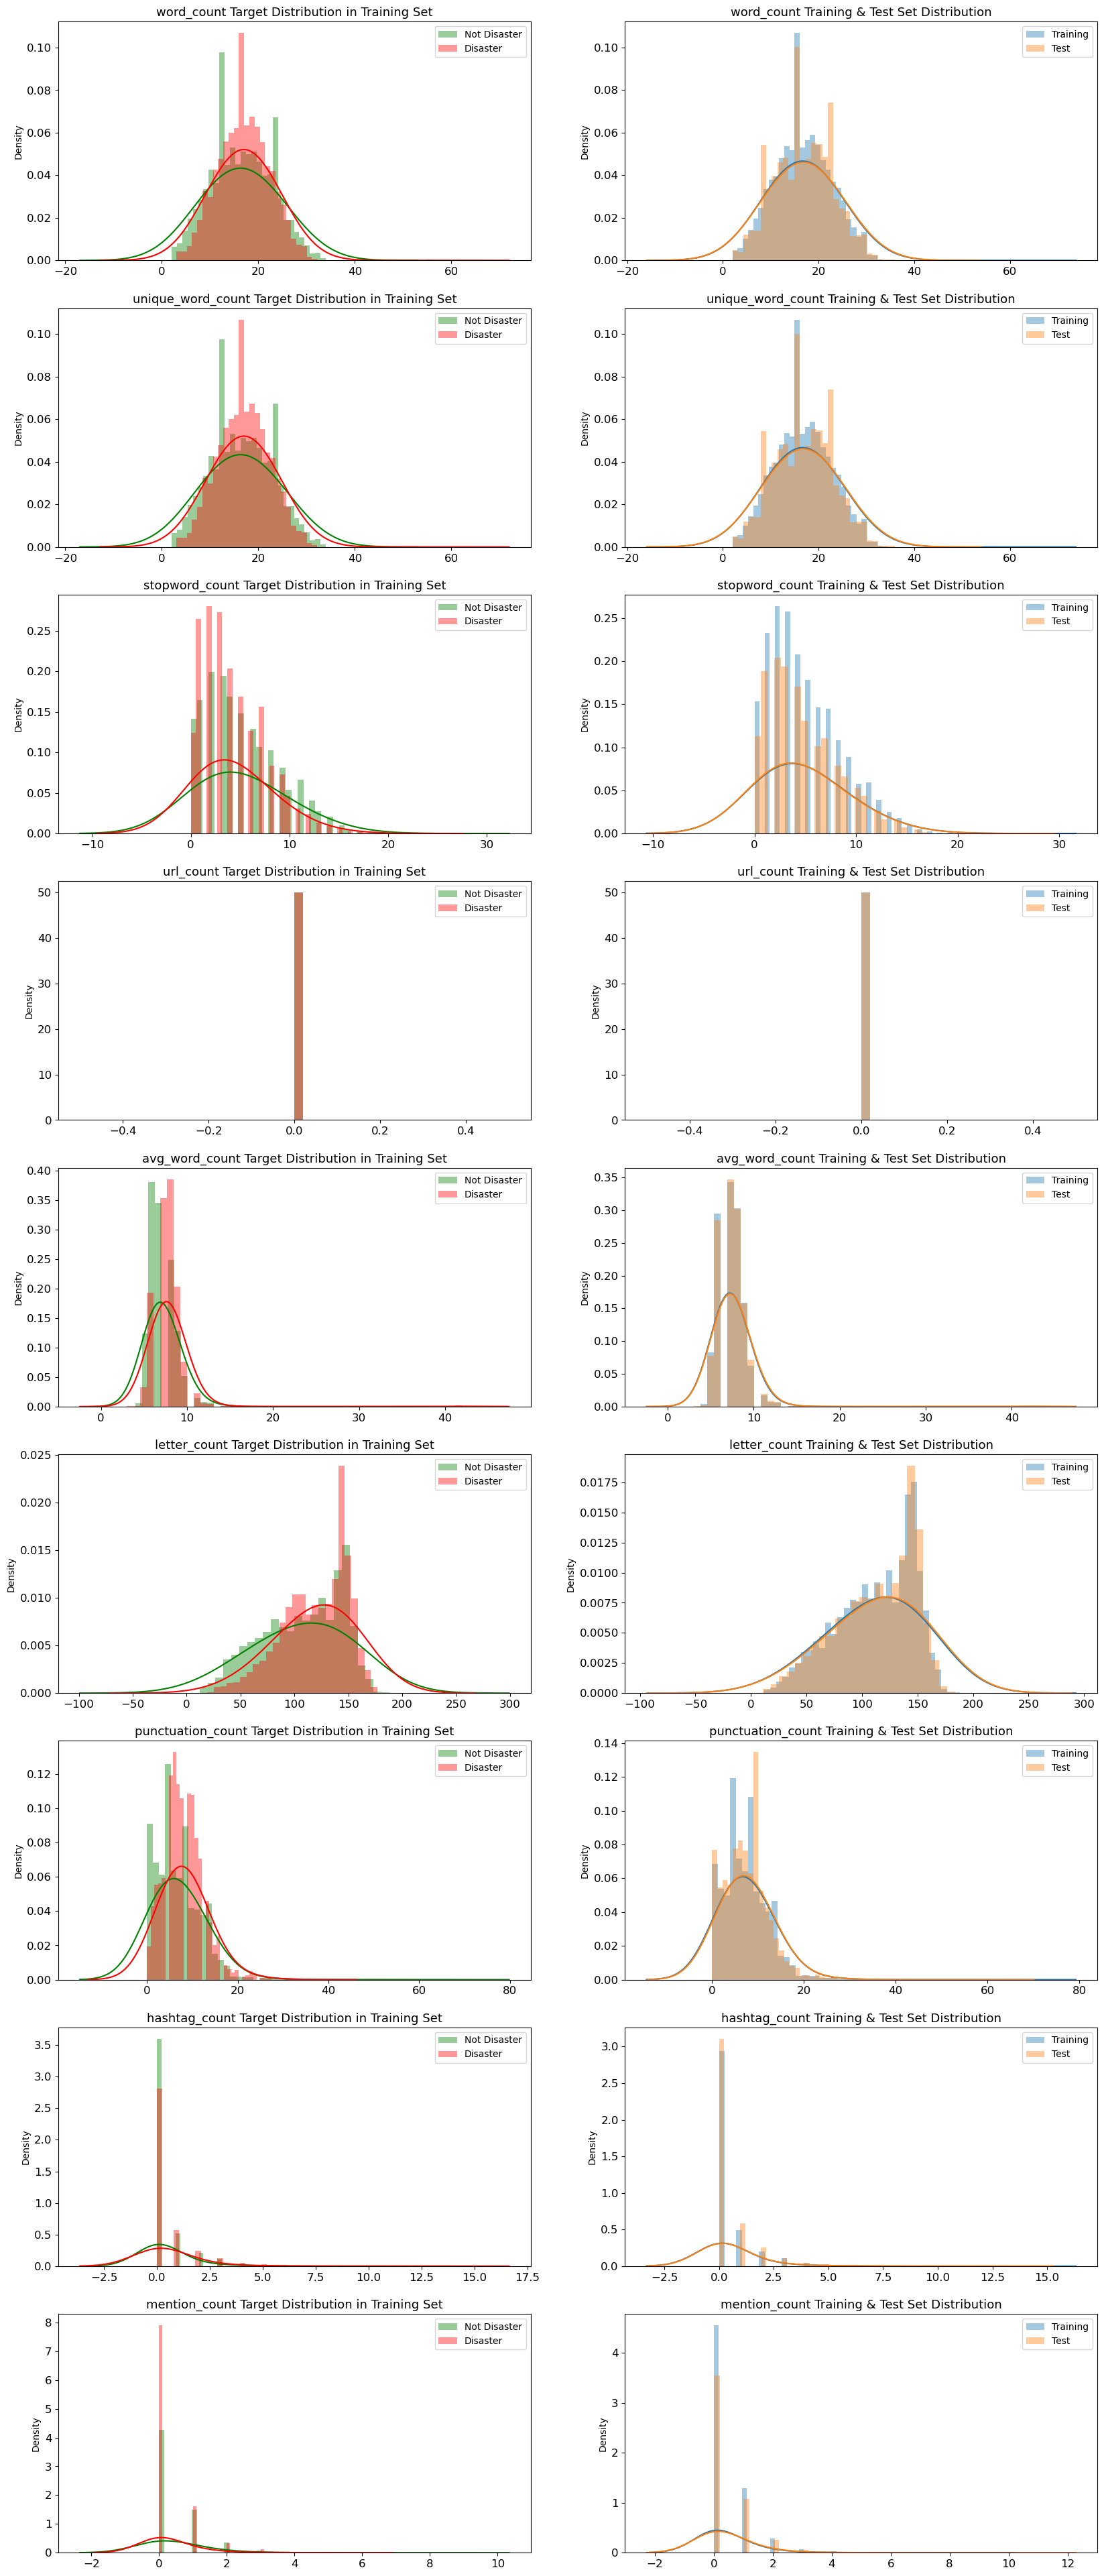

In [19]:
metafeature = ['word_count', 'unique_word_count', 'stopword_count', 'url_count', 'avg_word_count',
                'letter_count', 'punctuation_count', 'hashtag_count', 'mention_count']
disaster_tweets = data_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(metafeature), figsize=(20, 50), dpi=100)
for i, feature in enumerate(metafeature):
    sns.distplot(data_train.loc[~disaster_tweets][feature], label='Not Disaster', ax=axes[i][0], color='green',kde_kws={'bw':1})
    sns.distplot(data_train.loc[disaster_tweets][feature], label='Disaster', ax=axes[i][0], color='red',kde_kws={'bw': 1})

    sns.distplot(data_train[feature], label='Training', ax=axes[i][1],kde_kws={'bw': 1})
    sns.distplot(data_test[feature], label='Test', ax=axes[i][1],kde_kws={'bw':1})
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [20]:
data_train.drop(data_train.columns[[5,6,7,8,9,10,11,12,13]], axis=1, inplace=True)
data_test.drop(data_test.columns[[4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

In [21]:
def text_preprocessing(tweet): 
    
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',tweet) #removing hyperlinks starting with http and https
    
    tweet = re.sub(r'[\w\.-]+@[\w\.-]+','',tweet) #removing email id
    
    tweet = re.sub('www(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',tweet) #removing hyperlinks starting with www.
     
    emoji_pattern =re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)
    
    tweet=re.sub(r'(?<=@)\w+','',tweet) # removes mentions in the tweet
    
    tweet=re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','', tweet) #removes punctuations in the tweet
     
    tweet=re.sub(r'[0-9]+','',tweet) # removes numbers in the text
    
    tweet = tweet.lower()
    
    tweet = re.sub(r'\b\w{1,3}\b','',tweet) # removes all the words which have less than or equal to 3 letters.
    
    tweet = contractions.fix(tweet)
    
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x9d", "", tweet)
    tweet = re.sub(r"\x89", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"\n\n", "", tweet)
    tweet = re.sub(r"\n", "", tweet)
    
    tweet=tweet.strip()
    
    return tweet


In [22]:
def remove_words_less_than_2(tweet):
    if any(tweet in tweet for tweet in ['no','not','now','yes','ok']):
        return tweet
    else:
        tweet = re.sub(r'\b\w{1,2}\b','',tweet)
        return tweet

In [23]:
data_train['text']=data_train['text'].apply(lambda x: text_preprocessing(x))
data_train['text']=data_train['text'].apply(lambda x: remove_words_less_than_2(x))

data_test['text']=data_test['text'].apply(lambda x: text_preprocessing(x))
data_test['text']=data_test['text'].apply(lambda x: remove_words_less_than_2(x))

In [24]:
from tqdm import tqdm
train_preprocessed_reviews = []
# tqdm is for printing the status bar
for tweet in tqdm(data_train['text'].values):
    # https://gist.github.com/sebleier/554280
    tweet = ' '.join(e.lower() for e in tweet.split() if e.lower() not in final_stop_word)
    train_preprocessed_reviews.append(tweet.strip())

100%|██████████| 7531/7531 [00:00<00:00, 34444.06it/s]


In [25]:
from tqdm import tqdm
test_preprocessed_reviews = []
# tqdm is for printing the status bar
for tweet in tqdm(data_test['text'].values):
    # https://gist.github.com/sebleier/554280
    tweet = ' '.join(e.lower() for e in tweet.split() if e.lower() not in final_stop_word)
    test_preprocessed_reviews.append(tweet.strip())

100%|██████████| 3263/3263 [00:00<00:00, 33917.41it/s]


In [26]:
data_train['text']=train_preprocessed_reviews
data_test['text']=test_preprocessed_reviews

In [27]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,None,none deeds reason earthquake allah forgive,1
1,4,NaN,None,none forest fire near ronge sask canada,1
2,5,NaN,None,none residents asked shelter place notified of...,1
3,6,NaN,None,none people receive wildfires evacuation order...,1
4,7,NaN,None,none sent photo ruby alaska smoke wildfires po...,1


In [28]:
data_test.head()

,id,keyword,location,text
0,0,NaN,None,none happened terrible crash
1,2,NaN,None,none heard earthquake different cities stay sa...
2,3,NaN,None,none forest fire spot pond geese fleeing acros...
3,9,NaN,None,none apocalypse lighting spokane wildfires
4,11,NaN,None,none typhoon soudelor kills china taiwan


# **Frequency of words in uni, bi, trigrams**

In [29]:
disaster_tweets = data_train[data_train['target']==1]
non_disaster_tweets = data_train[data_train['target']==0]

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in final_stop_word]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50


# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in disaster_tweets['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in non_disaster_tweets['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
data_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
data_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in disaster_tweets['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in non_disaster_tweets['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
data_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
data_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in disaster_tweets['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in disaster_tweets['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
data_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
data_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

In [30]:
pd.concat([data_disaster_unigrams,data_disaster_bigrams,data_disaster_trigrams],axis=1,keys=['Unigrams','Bigrams','Trigrams']).head(25)

Unigrams                         Bigrams      \
             0       1                       0   1   
0         none  1049.0          suicide bomber  54   
1         fire   177.0     northern california  42   
2   california   150.0           united states  36   
3         news   140.0     california wildfire  34   
4          not   131.0         suicide bombing  33   
5     disaster   112.0             homes razed  29   
6       police   107.0          razed northern  28   
7      suicide   104.0            latest homes  28   
8       people   103.0       burning buildings  28   
9       killed    93.0     severe thunderstorm  27   
10   hiroshima    88.0             none latest  26   
11       fires    84.0  conclusively confirmed  25   
12       storm    83.0   wreckage conclusively  25   
13       crash    83.0        bomber detonated  25   
14    families    79.0   outbreak legionnaires  25   
15   emergency    76.0          fatal outbreak  25   
16        city    75.0          affected fatal  25   
17       train    73.0       families affected  25   
18     nuclear    70.0   families legionnaires  25   
19        bomb    69.0             mass murder  25   
20    wildfire    69.0            debris found  25   
21   buildings    68.0      confirmed malaysia  24   
22      attack    68.0        sandstorm minute  24   
23       world    67.0     swallowed sandstorm  24   
24     bombing    66.0       airport swallowed  24   

                               Trigrams        
                                      0     1  
0          northern california wildfire  29.0  
1                  homes razed northern  28.0  
2                    latest homes razed  28.0  
3             razed northern california  27.0  
4       wreckage conclusively confirmed  25.0  
5              suicide bomber detonated  25.0  
6                     none latest homes  25.0  
7               affected fatal outbreak  25.0  
8               families affected fatal  25.0  
9       conclusively confirmed malaysia  24.0  
10           swallowed sandstorm minute  24.0  
11          airport swallowed sandstorm  24.0  
12              watch airport swallowed  24.0  
13       legionnaires families affected  24.0  
14       families legionnaires families  24.0  
15                bomber detonated bomb  23.0  
16    disaster typhoondevastated saipan  23.0  
17  declares disaster typhoondevastated  23.0  
18              obama declares disaster  23.0  
19                   turkey army trench  22.0  
20                     bomb turkey army  22.0  
21                detonated bomb turkey  22.0  
22          fatal outbreak legionnaires  22.0  
23            costlier bigger projected  22.0  
24                spill costlier bigger  22.0


Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's CountVectorizer and few other techniques to count the words in each tweet and turn them into vectors such that making the data compatible with the machine learning model.

Note: a vector is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.


## **Bag of words:** Unigram

In [31]:
count_vectorizer = feature_extraction.text.CountVectorizer() 
#Gram size increase the dimension of the text vector increases.


data_train_vectors = count_vectorizer.fit_transform(data_train["text"])

data_test_vectors = count_vectorizer.transform(data_test["text"])


## **Bag of words:** Bigram

In [32]:
count_vectorizer_bigram = feature_extraction.text.CountVectorizer(2,2) 
#1gram as the gram size increase the dimension of the text vector increases.


data_train_vectors_bigram = count_vectorizer_bigram.fit_transform(data_train["text"])


data_test_vectors_bigram = count_vectorizer_bigram.transform(data_test["text"])


As increasing the Ngram range increases the dimensionality and also since models with more than 2 gram range gave very low f1 score we can move to the next transformation method.

Models trained with **Bag of words gave poor results**, as we know Bag of words doesn't retain semantic meaning so we choose work with TF IDF Transformation

## **TF IDF Transformation**

In [33]:
tf_idf_vect = TfidfVectorizer()

tf_idf_vectors_train = tf_idf_vect.fit_transform(data_train['text'])

print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_train.get_shape())



tf_idf_vectors_test = tf_idf_vect.transform(data_test['text'])

print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_test.get_shape())


the shape of out text TFIDF vectorizer  (7531, 15027)
the shape of out text TFIDF vectorizer  (3263, 15027)


# TF IDF Transformation : Bigrams

In [34]:
tf_idf_vect_bigram = TfidfVectorizer(ngram_range=(2,2),sublinear_tf=True)
tf_idf_vect_bigram.fit(data_train['text'])
print("some sample features(unique words in the corpus)",tf_idf_vect_bigram.get_feature_names()[0:10])
print('='*50)

tf_idf_vectors_train_bigram = tf_idf_vect_bigram.transform(data_train['text'])
print("the type of count vectorizer ",type(tf_idf_vectors_train_bigram))
print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_train_bigram.get_shape())
print("the number of unique words in bigrams ", tf_idf_vectors_train_bigram.get_shape()[1])


tf_idf_vectors_test_bigram = tf_idf_vect_bigram.transform(data_test['text'])
print("the type of count vectorizer ",type(tf_idf_vectors_test_bigram))
print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_test_bigram.get_shape())
print("the number of unique words in bigrams ", tf_idf_vectors_test_bigram.get_shape()[1])

some sample features(unique words in the corpus) ['aaaa lemme', 'aaaaaaallll even', 'aampb pipeliners', 'aampw pmclose', 'aannnnd reddit', 'aarhus central', 'aashiqui actress', 'abandon plans', 'abandon ship', 'abandon west']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (7531, 43870)
the number of unique words in bigrams  43870
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3263, 43870)
the number of unique words in bigrams  43870


# TF IDF Transformation: Trigrams

In [35]:
tf_idf_vect_trigram = TfidfVectorizer(ngram_range=(3,3),sublinear_tf=True)
tf_idf_vect_trigram.fit(data_train['text'])
print("some sample features(unique words in the corpus)",tf_idf_vect_trigram.get_feature_names()[0:10])
print('='*50)

tf_idf_vectors_train_trigram = tf_idf_vect_trigram.transform(data_train['text'])
print("the type of count vectorizer ",type(tf_idf_vectors_train_trigram))
print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_train_trigram.get_shape())
print("the number of unique words in bigrams ", tf_idf_vectors_train_trigram.get_shape()[1])


tf_idf_vectors_test_trigram = tf_idf_vect_trigram.transform(data_test['text'])
print("the type of count vectorizer ",type(tf_idf_vectors_test_trigram))
print("the shape of out text TFIDF vectorizer ",tf_idf_vectors_test_trigram.get_shape())
print("the number of unique words in bigrams ", tf_idf_vectors_test_trigram.get_shape()[1])

some sample features(unique words in the corpus) ['aaaa lemme move', 'aaaaaaallll even season', 'aampw pmclose help', 'aannnnd reddit quarantine', 'aarhus central jutland', 'aashiqui actress aggarwal', 'abandon plans construct', 'abandon ship evacuate', 'abandon west philippine', 'abandoned aircraft evacuation']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (7531, 41921)
the number of unique words in bigrams  41921
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3263, 41921)
the number of unique words in bigrams  41921


# **Logistic Regression**

In [36]:
model_lr = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid_lr = dict(solver=solvers,penalty=penalty,C=c_values)
cv_lr = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=grid_lr, n_jobs=-1, cv=cv_lr, scoring='f1',error_score=0)

grid_result_lr = grid_search_lr.fit(tf_idf_vectors_train, data_train['target'])
# summarize results
print("Best: %f using %s" % (grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: 0.730672 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [37]:
model_svc = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid_svc = dict(kernel=kernel,C=C,gamma=gamma)
cv_svc = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_svc = GridSearchCV(estimator=model_svc, param_grid=grid_svc, n_jobs=-1, cv=cv_svc, scoring='f1',error_score=0)
grid_result_svc = grid_search_svc.fit(tf_idf_vectors_train, data_train['target'])
# summarize results
print("Best: %f using %s" % (grid_result_svc.best_score_, grid_result_svc.best_params_))

Best: 0.740912 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [38]:
from sklearn.svm import LinearSVC
model_linsvc = LinearSVC()
loss = ['hinge', 'squared_hinge']
C = [50, 10, 1.0, 0.1, 0.01]
class_weight =['balanced']
# define grid search
grid_linsvc = dict(loss=loss,C=C,class_weight=class_weight)
cv_linsvc = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_linsvc = GridSearchCV(estimator=model_linsvc, param_grid=grid_linsvc, n_jobs=-1, cv=cv_linsvc, scoring='f1',error_score=0)
grid_result_linsvc = grid_search_linsvc.fit(tf_idf_vectors_train, data_train['target'])
# summarize results
print("Best: %f using %s" % (grid_result_linsvc.best_score_, grid_result_linsvc.best_params_))

Best: 0.748830 using {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}


**Since LinearSVC model gave the highest F1 score among all the other models, We choose to predict the test dataset using Linear SVC with the best possible hyperparameters obtained from gridsearchCV.**

In [39]:
model_linsvc = LinearSVC(C=0.1,class_weight='balanced',loss='squared_hinge')

model_linsvc_result = model_linsvc.fit(tf_idf_vectors_train, data_train['target'])



In [40]:
y_pred = model_linsvc.predict(tf_idf_vectors_train)
y_act = data_train['target']
from sklearn.metrics import classification_report

In [41]:
print(classification_report(y_act, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4312
           1       0.91      0.85      0.88      3219

    accuracy                           0.90      7531
   macro avg       0.90      0.89      0.89      7531
weighted avg       0.90      0.90      0.90      7531



In [42]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [43]:
sample_submission["target"] = model_linsvc.predict(tf_idf_vectors_test)

In [44]:
sample_submission["target"]

0       1
1       1
2       1
3       0
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64

In [45]:
sample_submission.to_csv("submission.csv", index=False)